# Classic Machine Learning Methods

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
import joblib
import matplotlib.pyplot as plt
import numpy as np


In [9]:
df_train = pd.read_csv("data/ptbdb_train.csv", header=None) 
df_test = pd.read_csv("data/ptbdb_test.csv", header=None)

x_train = df_train[df_train.columns[0:187]].values
y_train = df_train[df_train.columns[187]].values
x_test = df_test[df_test.columns[0:187]].values
y_test = df_test[df_test.columns[187]].values

## Train ml models on raw data

### Regularized logistic regression

In [9]:
# logisitic regression, find the best hyperparameters

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
y_pred = grid_search.predict(x_test)
print("Test set F1 score: {:.2f}".format(f1_score(y_test, y_pred)))



Best parameters: {'C': 0.1}
Test set F1 score: 0.88


### Train a bosted model

In [50]:


param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7, 9]}
clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
y_pred = grid_search.predict(x_test)
print("Test set F1 score: {:.4f}".format(f1_score(y_test, y_pred)))


[LightGBM] [Info] Number of positive: 6723, number of negative: 2589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41831
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721972 -> initscore=0.954263
[LightGBM] [Info] Start training from score 0.954263
[LightGBM] [Info] Number of positive: 6723, number of negative: 2590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41838
[LightGBM] [Info] Number of data points in the train set: 9313, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721894 -> initscore=0.953877
[LightGBM] [Info] Start training from score 0.953877
[LightGBM] [Info] 

## Build pipeline with new engineered feature


In [24]:
# long format with id and time columns
df_train_long = pd.DataFrame(df_train[df_train.columns[0:187]])
df_train_long['id'] = df_train_long.index
df_train_long = df_train_long.melt(id_vars='id', var_name='time')
df_train_long['time'] = df_train_long['time'].astype(int)

df_test_long = pd.DataFrame(df_test[df_test.columns[0:187]])
df_test_long['id'] = df_test_long.index
df_test_long = df_test_long.melt(id_vars='id', var_name='time')
df_test_long['time'] = df_test_long['time'].astype(int)



In [25]:
# define new dataset with new features made with tsfresh
X_train = extract_features(df_train_long, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())


Feature Extraction: 100%|██████████| 20/20 [09:08<00:00, 27.43s/it]


In [26]:
# extract features for test set
X_test = extract_features(df_test_long, column_id='id', column_sort='time', default_fc_parameters=EfficientFCParameters())

Feature Extraction:   0%|          | 0/20 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


In [27]:
print(X_train.shape)
print(X_test.shape)

(11641, 777)
(2911, 777)


In [28]:
X_train_wo_nan = X_train.dropna(axis=1)
X_test_wo_nan = X_test.dropna(axis=1)

In [30]:
print(X_train_wo_nan.shape)
print(X_test_wo_nan.shape)

(11641, 747)
(2911, 747)


In [3]:
# save the new datasets with extracted features
X_train_wo_nan.to_csv("data/X_train_new_features.csv")
X_test_wo_nan.to_csv("data/X_test_new_features.csv")

NameError: name 'X_train_wo_nan' is not defined

In [10]:
X_train_wo_nan = pd.read_csv("data/X_train_new_features.csv", index_col = 0)
X_test_wo_nan = pd.read_csv("data/X_test_new_features.csv", index_col = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_wo_nan)
X_test = scaler.transform(X_test_wo_nan)

In [5]:
# train logistic regression on new features

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = LogisticRegression(max_iter=10000)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model

y_pred = grid_search.predict(X_test)
print("Test set F1 score: {:.2f}".format(f1_score(y_test, y_pred)))



NameError: name 'y_train' is not defined

Number of selected features: 705


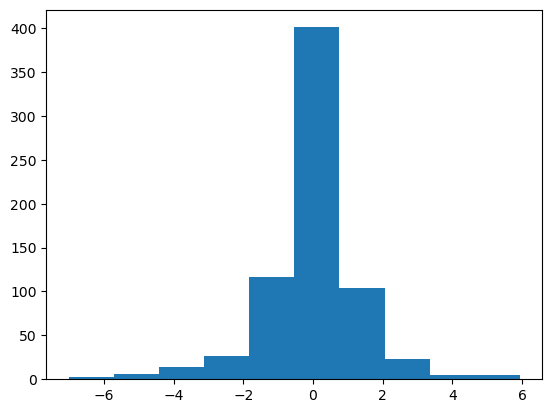

In [14]:
# show selected features
selected_features = X_train_wo_nan.columns[grid_search.best_estimator_.coef_[0] != 0]
# number of selected features
print("Number of selected features: {}".format(len(selected_features)))
# plot distribution of coefficients of selected features
plt.hist(grid_search.best_estimator_.coef_[0][grid_search.best_estimator_.coef_[0] != 0])
plt.show()


In [15]:
# train lightgbm on new features
param_grid = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7, 9]}
clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))

# test the model
y_pred = grid_search.predict(X_test)
print("Test set F1 score: {:.4f}".format(f1_score(y_test, y_pred)))



[LightGBM] [Info] Number of positive: 6723, number of negative: 2589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166505
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 701
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721972 -> initscore=0.954263
[LightGBM] [Info] Start training from score 0.954263
[LightGBM] [Info] Number of positive: 6723, number of negative: 2590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166533
[LightGBM] [Info] Number of data points in the train set: 9313, number of used features: 702
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.721894 -> initscore=0.953877
[LightGBM] [Info] Start training from score 0.953877
[LightGBM] [Info

In [17]:
# save gbm model
joblib.dump(grid_search.best_estimator_, "models/gbm_model.pkl")

['models/gbm_model.pkl']

In [11]:
load_model = joblib.load("models/gbm_model.pkl")
y_pred = load_model.predict(X_test)
print("Test set F1 score: {:.4f}".format(f1_score(y_test, y_pred)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test set F1 score: 0.9934


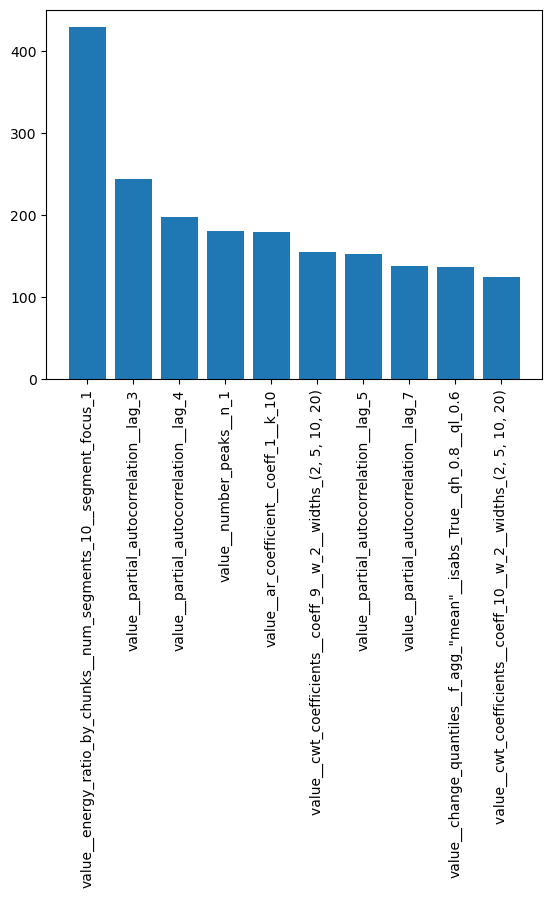

In [18]:
# plot feature importance for the first 10 features

importances = load_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(10), importances[indices[0:10]])
plt.xticks(range(10), X_train_wo_nan.columns[indices[0:10]], rotation=90)
plt.show()

